## Introduction
This project performs a data analysis on stock price data for NVIDIA (NVDA) and Tesla (TSLA) and compares their performance to the S&P 500 benchmark. The analysis aims to:
- Visualize the stock price trends for NVDA and TSLA.
- Calculate key financial metrics such as daily returns, Sharpe ratios, and cumulative returns.
- Evaluate the performance of a portfolio consisting of NVDA and TSLA stocks compared to the S&P 500.

The data is sourced using the `yfinance` library, which provides historical stock price data. The analysis covers the period from January 1, 2024, to December 31, 2024.

## Data Fetching and Visualization
In this section, we fetch historical stock price data for NVDA and TSLA using the `yfinance` library. The data includes daily closing prices for the year 2024.

We then visualize the closing prices of both stocks to identify trends and patterns. This helps us understand how the stocks performed over the year and whether there are any notable similarities or differences in their price movements.

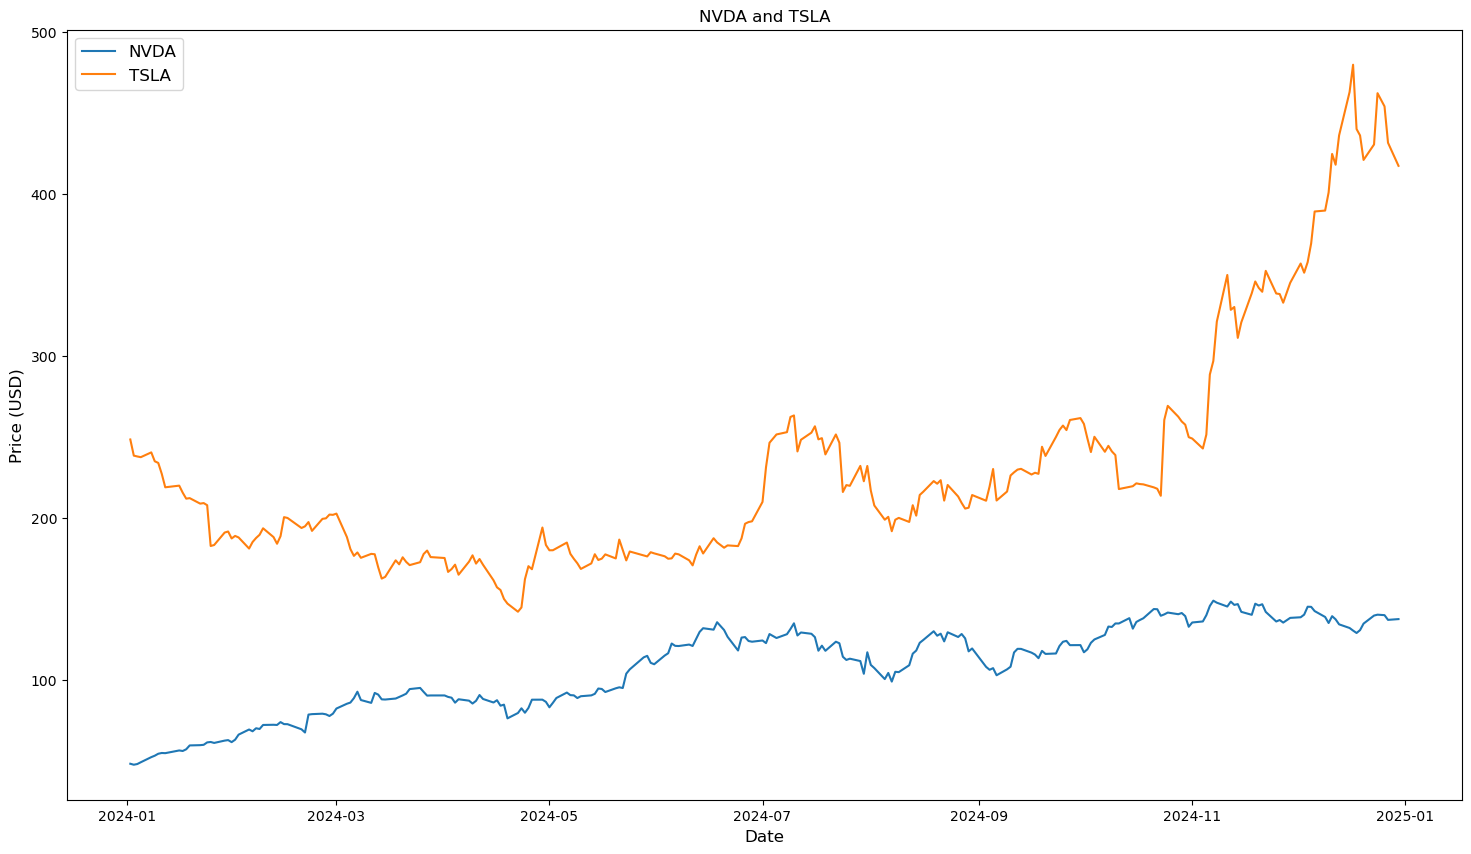

In [98]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

ticker1 = 'NVDA'
ticker2 = 'TSLA'

start_date = pd.to_datetime('2024-01-01')
end_date = pd.to_datetime('2024-12-31')

data1 = yf.Ticker(ticker1).history(start=start_date, end=end_date)
data2 = yf.Ticker(ticker2).history(start=start_date, end=end_date)

plt.figure(figsize=(18, 10))
plt.title(ticker1 + ' and ' + ticker2 )
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.plot(data1['Close'])
plt.plot(data2['Close'])
plt.legend([ticker1, ticker2], loc='upper left', fontsize=12)
plt.show()

## Portfolio Analysis
In this section, we analyze the performance of a portfolio consisting of equal weights (50% each) of NVDA and TSLA stocks. The analysis includes the following steps:
1. **Daily Returns:** Calculate the daily percentage change in stock prices.
2. **Excess Returns:** Adjust the daily returns by subtracting the daily risk-free rate (derived from the 10-year Treasury bond yield).
3. **Sharpe Ratio:** Measure the risk-adjusted return of the portfolio and individual stocks.
4. **Cumulative Returns:** Calculate the cumulative growth of the portfolio and individual stocks over time.

The Sharpe ratio is a key metric for evaluating the performance of an investment relative to its risk. A higher Sharpe ratio indicates better risk-adjusted returns.

NVDA Sharpe ratio: 2.1903354888419755
TSLA Sharpe ratio: 1.0622499252014004
Portfolio Sharpe ratio: 2.0081726843104235


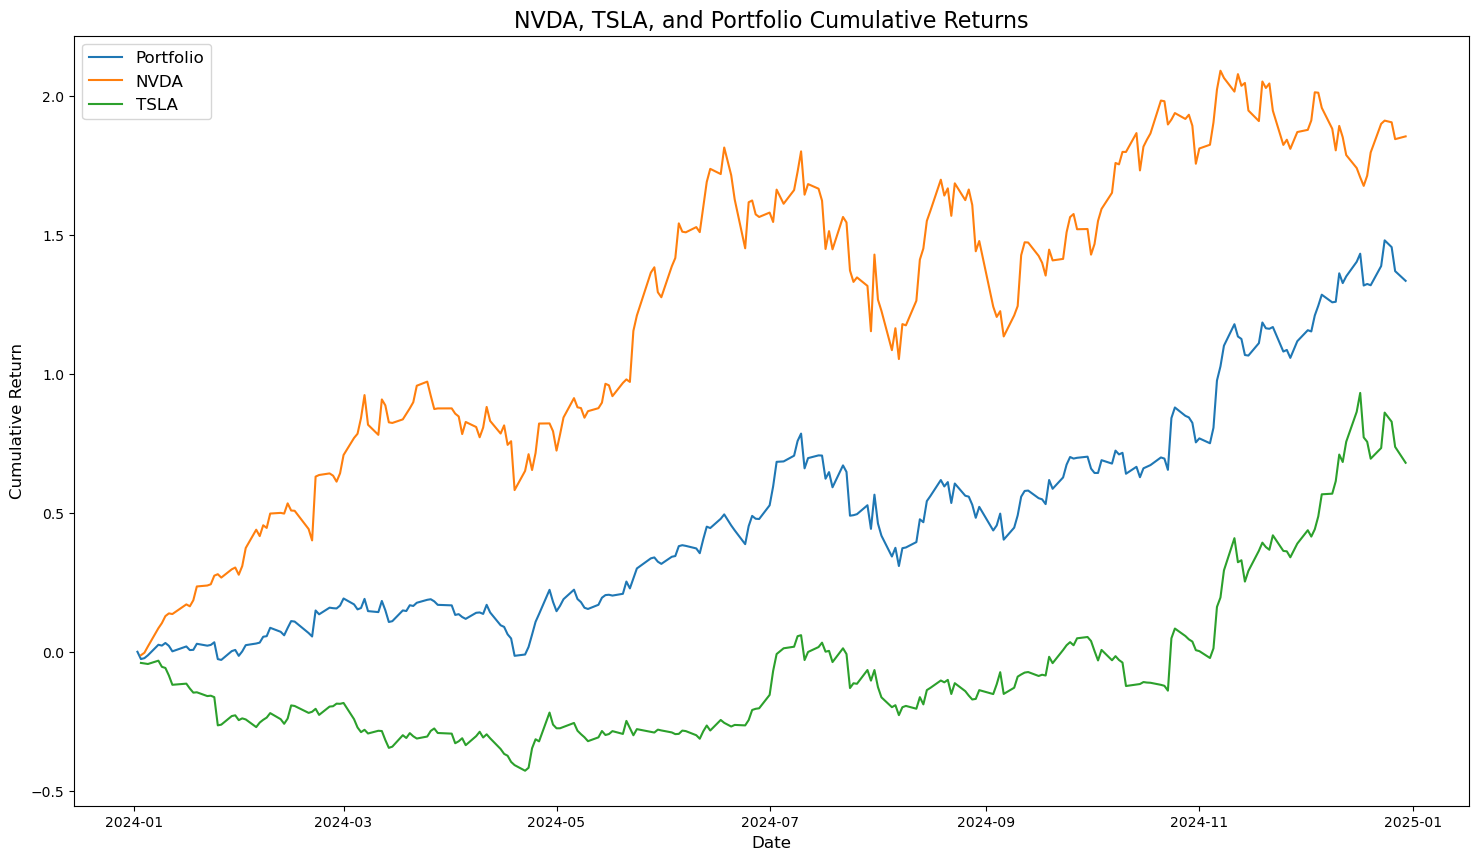

In [99]:
# Percentage change calculation - Fractional change between the current and a prior element.
data1['daily_return'] = data1['Close'].pct_change()
data2['daily_return'] = data2['Close'].pct_change()

# Risk-free rate is typically the 10-year treasury bond yield.
risk_free_rate = 0.045  # 4.5% on 1st Jan 2025
daily_risk_free_rate = risk_free_rate / 252 # 252 trading days in a year

# Excess daily return calculation - daily return minus daily risk-free rate
data1['excess_daily_return'] = data1['daily_return'] - daily_risk_free_rate
data2['excess_daily_return'] = data2['daily_return'] - daily_risk_free_rate

# Sharpe ratio calculation - average of excess daily return divided by standard deviation of excess daily return, multiplied by square root of 252 (trading days in a year)
data1_sharpe = data1['excess_daily_return'].mean() / data1['excess_daily_return'].std() * (252 ** 0.5)
data2_sharpe = data2['excess_daily_return'].mean() / data2['excess_daily_return'].std() * (252 ** 0.5)

print(ticker1 + ' Sharpe ratio: ' + str(data1_sharpe))
print(ticker2 + ' Sharpe ratio: ' + str(data2_sharpe))

# Portfolio initialised for further anaysis - Concatenated daily return data for both tickers into one dataframe to enable easier calculation
portfolio = pd.concat([data1['daily_return'], data2['daily_return']], axis=1)
portfolio.columns = [ticker1, ticker2]

# Equal weight allocation to both tickers
weights = [0.5, 0.5] 

# Daily return for the portfolio
portfolio['portfolio_return'] = (portfolio * weights).sum(axis=1)

# Excess daily return for the portfolio
portfolio['portfolio_excess_return'] = portfolio['portfolio_return'] - daily_risk_free_rate

# Portfolio Sharpe Ratio
portfolio_sharpe = (portfolio['portfolio_excess_return'].mean() / portfolio['portfolio_excess_return'].std()) * (252 ** 0.5)

print('Portfolio Sharpe ratio: ' + str(portfolio_sharpe))

# Cumulative return calculation - Daily return plus 1, cumulative product, minus 1
portfolio['portfolio_cumulative_return'] = (1 + portfolio['portfolio_return']).cumprod() - 1
portfolio[f'{ticker1}_cumulative_return'] = (1 + portfolio[ticker1]).cumprod() - 1
portfolio[f'{ticker2}_cumulative_return'] = (1 + portfolio[ticker2]).cumprod() - 1

plt.figure(figsize=(18, 10))
plt.title(f"{ticker1}, {ticker2}, and Portfolio Cumulative Returns", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.plot(portfolio['portfolio_cumulative_return'], label="Portfolio")
plt.plot(portfolio[f'{ticker1}_cumulative_return'], label=ticker1)
plt.plot(portfolio[f'{ticker2}_cumulative_return'], label=ticker2)
plt.legend(loc='upper left', fontsize=12)
plt.show()


## Benchmark Comparison
To evaluate the performance of the portfolio, we compare it to the S&P 500, a widely used benchmark for equity markets. The S&P 500 represents the performance of the 500 largest publicly traded companies in the U.S. and serves as a proxy for the overall market.

We calculate the daily returns, cumulative returns, and Sharpe ratio for the S&P 500 and compare them to the portfolio. This comparison helps us determine whether the portfolio outperformed or underperformed the broader market.

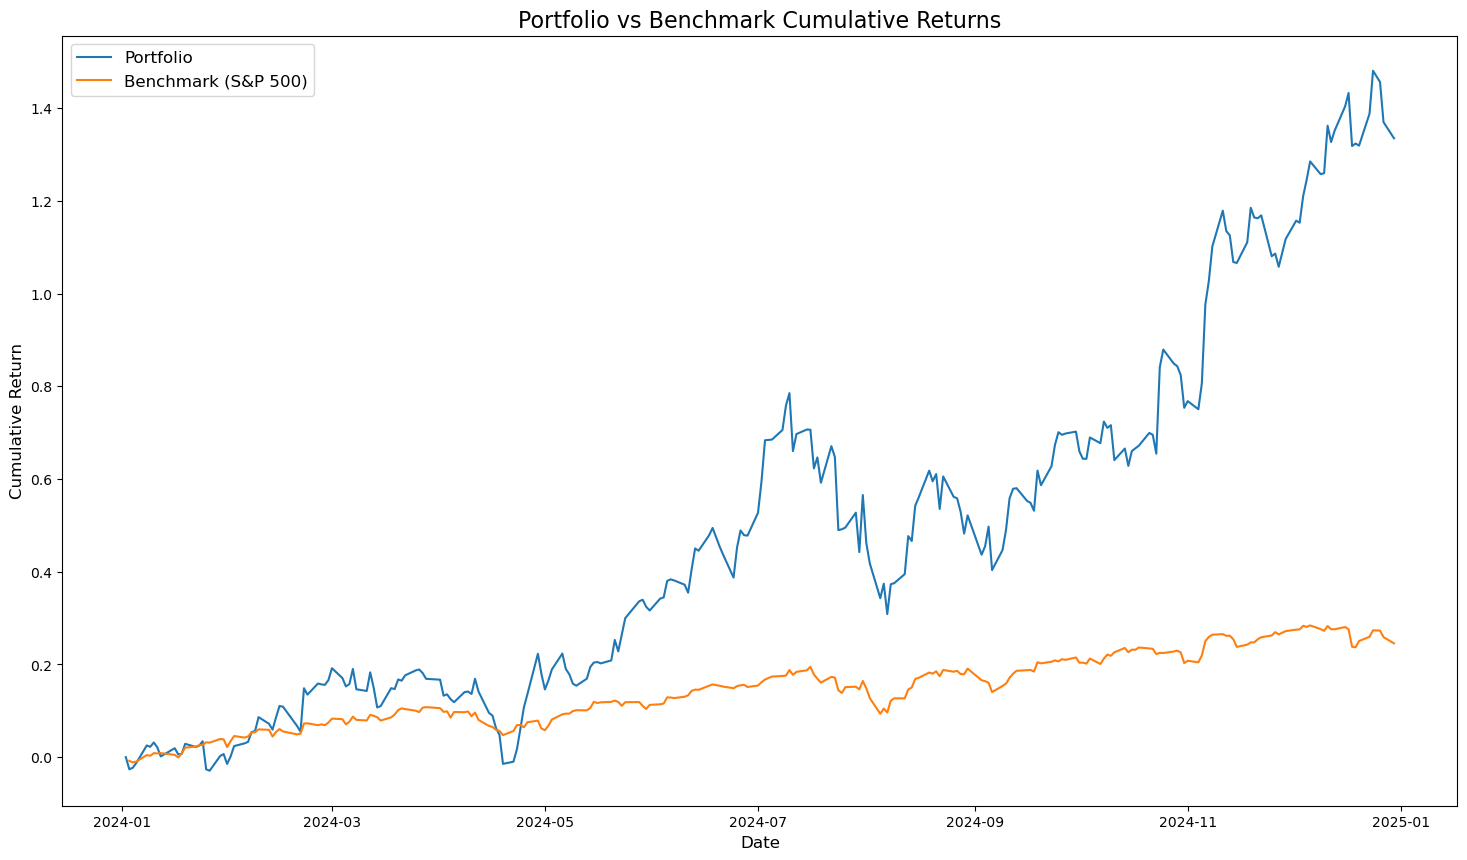

In [100]:
# S&P500 used as benchmark for comparison with the portfolio
benchmark_ticker = '^GSPC'

benchmark_data = yf.Ticker(benchmark_ticker).history(start=start_date, end=end_date)

# Benchmark daily return and cumulative return calculation
benchmark_data['daily_return'] = benchmark_data['Close'].pct_change()
benchmark_data['cumulative_return'] = (1 + benchmark_data['daily_return']).cumprod() - 1

# Cumulative return (calculated above) for the portfolio added and benchmark added to the portfolio dataframe
portfolio['benchmark_cumulative_return'] = benchmark_data['cumulative_return']

plt.figure(figsize=(18, 10))
plt.title('Portfolio vs Benchmark Cumulative Returns', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.plot(portfolio['portfolio_cumulative_return'], label='Portfolio')
plt.plot(portfolio['benchmark_cumulative_return'], label='Benchmark (S&P 500)')
plt.legend(fontsize=12)
plt.show()


In [101]:
from sklearn.ensemble import IsolationForest

anomaly_data1 = data1[['Close']]

# Isolation forest model means that the data is split into two parts, inliers and outliers, based on the isolation forest algorithm.
outlier_model = IsolationForest(contamination=0.01) # Contamination controls the sensitivity of the model to outliers with .01 meaning 1% of the data is considered an outlier
outlier_model.fit(anomaly_data1)

# Predict the anomalies in the data,
data1['Anomaly'] = outlier_model.predict(anomaly_data1)
print(data1[data1['Anomaly'] == -1]) # -1 indicates an anomaly in the data whereas 1 indicates normal data


anomaly_data2 = data2[['Close']]

outlier_model = IsolationForest(contamination=0.01) 
outlier_model.fit(anomaly_data2)

data2['Anomaly'] = outlier_model.predict(anomaly_data1)
print(data2[data2['Anomaly'] == -1]) 

                                 Open        High         Low       Close  \
Date                                                                        
2024-01-03 00:00:00-05:00   47.471539   48.170339   47.306585   47.555515   
2024-01-05 00:00:00-05:00   48.448262   49.532953   48.292304   49.083080   
2024-11-07 00:00:00-05:00  146.379917  148.919735  146.159931  148.869751   

                              Volume  Dividends  Stock Splits  daily_return  \
Date                                                                          
2024-01-03 00:00:00-05:00  320896000        0.0           0.0     -0.012436   
2024-01-05 00:00:00-05:00  415039000        0.0           0.0      0.022897   
2024-11-07 00:00:00-05:00  207323300        0.0           0.0      0.022457   

                           excess_daily_return  Anomaly  
Date                                                     
2024-01-03 00:00:00-05:00            -0.012614       -1  
2024-01-05 00:00:00-05:00             0.0227

## Conclusion
The analysis reveals the following key insights:
1. **Portfolio Performance:** The portfolio consisting of NVDA and TSLA stocks delivered strong cumulative returns over the year. However, its Sharpe ratio was lower than that of the S&P 500, indicating lower risk-adjusted returns.
2. **Benchmark Comparison:** The S&P 500 outperformed the portfolio in terms of risk-adjusted returns, as evidenced by its higher Sharpe ratio.
3. **Stock Performance:** NVDA and TSLA exhibited different performance trends, with NVDA showing more consistent growth and TSLA experiencing higher volatility.
3. **Predictive model**

These findings suggest that while the portfolio delivered higher absolute returns, it also carried higher risk compared to the S&P 500. Future analysis could explore alternative portfolio weightings or additional stocks to improve risk-adjusted returns.